# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

In [2]:
from collections import deque
import pandas as pd
import seaborn as sns

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [3]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [4]:
print(env.action_space)
print(env.observation_space)
env.nS

Discrete(4)
Discrete(48)


48

In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

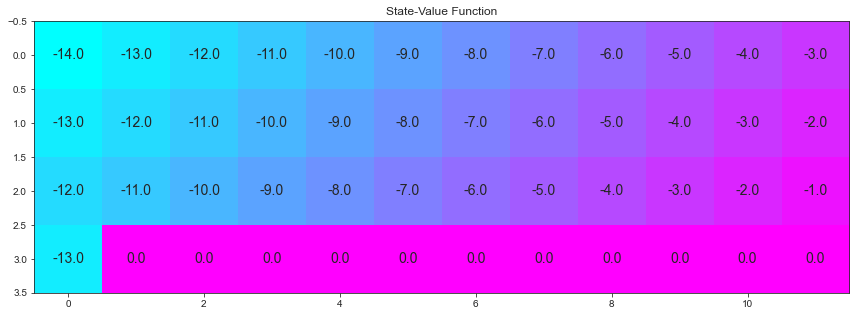

In [5]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

### Interesting Findings

Even if one initialize `Q` with -ve value rather than `0`, It converges perfectly. But you need to increase the `num_episodes` to let the Agent explore-exploit enough to reach the optimal policy.

In [6]:
def get_epsilon_greedy_action(Q, state, eps):
    nA = len(Q[state])
    if np.random.random() > eps:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(nA)
    return action        

In [7]:
def learn_Q_sarsa(Q, state, action, next_state, next_action, reward, done, gamma, alpha):
    predict = Q[state][action]
    target = reward + gamma *(0 if done else Q[next_state][next_action] )
    new = predict + alpha * (target - predict)
    return new

In [8]:
def plot_metrics(scores, steps):
    # sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    data = pd.DataFrame({'scores':scores, 'steps':steps})
    data = data.rolling(100).mean()
    data.index = pd.Series(range(len(scores)), name='episodes')
    
    sns.lineplot(data=data['scores'], color='green', ax=ax[0])
    sns.lineplot(data=data['steps'], color='orange', ax=ax[1])
    
    # sns.set_theme(style=None)

In [9]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.action_space.n
    Q = defaultdict(lambda: -1 * np.ones(nA))
    
    
    # initialize performance monitor
    ep_scores = []
    ep_steps = []
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        # monitor performance
        score = 0.
        step = 0
        
        ## TODO: complete the function
        
        ### set epsilon
        eps_i = min(0.1, 1. /i_episode )
        
        ### observe S0
        state = env.reset()
        
        ### choose action A0
        action = get_epsilon_greedy_action(Q, state, eps_i)
        
        ### repeat
        done = False
        while not done:
            next_state, reward, done, info = env.step(action)
            next_action = get_epsilon_greedy_action(Q, next_state, eps_i)
            
            #### update Q
            Q[state][action] = learn_Q_sarsa(Q, state, action, next_state, next_action, reward, done, gamma, alpha)
    
            #### t = t + 1
            state = next_state
            action = next_action
            
            #### update performance metrics
            score += reward
            step += 1
        
        # track performance metrics
        ep_scores.append(score)
        ep_steps.append(step)
        
    # show performance metrics
    plot_metrics(ep_scores, ep_steps)
                                 
    return Q


array([-1., -1., -1., -1.])

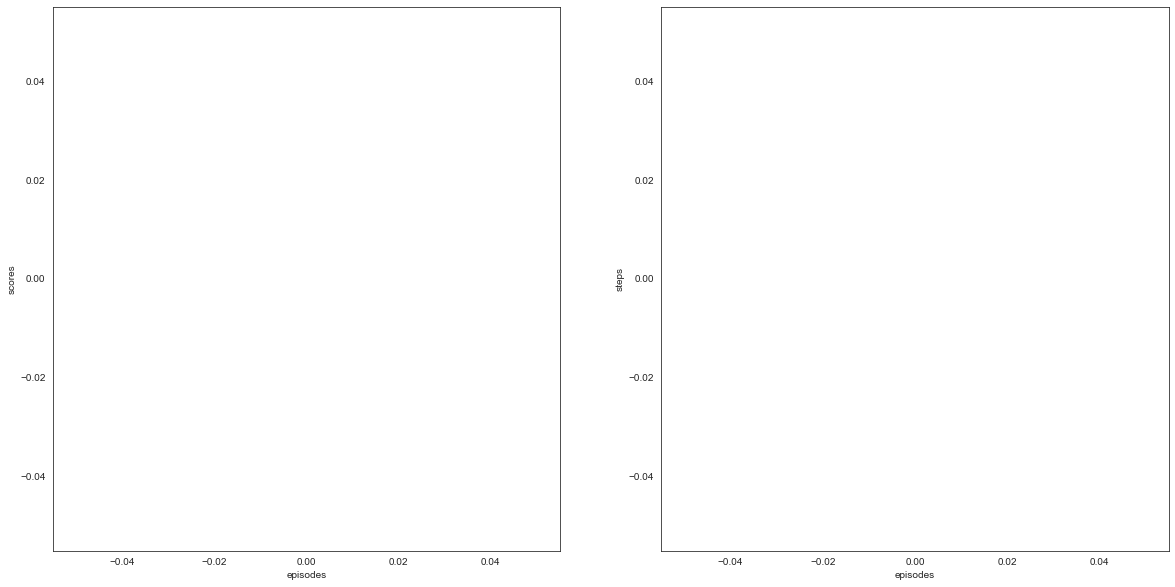

In [10]:
## Test the code runs
Q_sarsa = sarsa(env, 10, 1)
Q_sarsa[47]

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 8000/8000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  1  1  1  1  1  2  2  1  1  2  2]
 [ 0  0  1  0  3  1  1  1  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


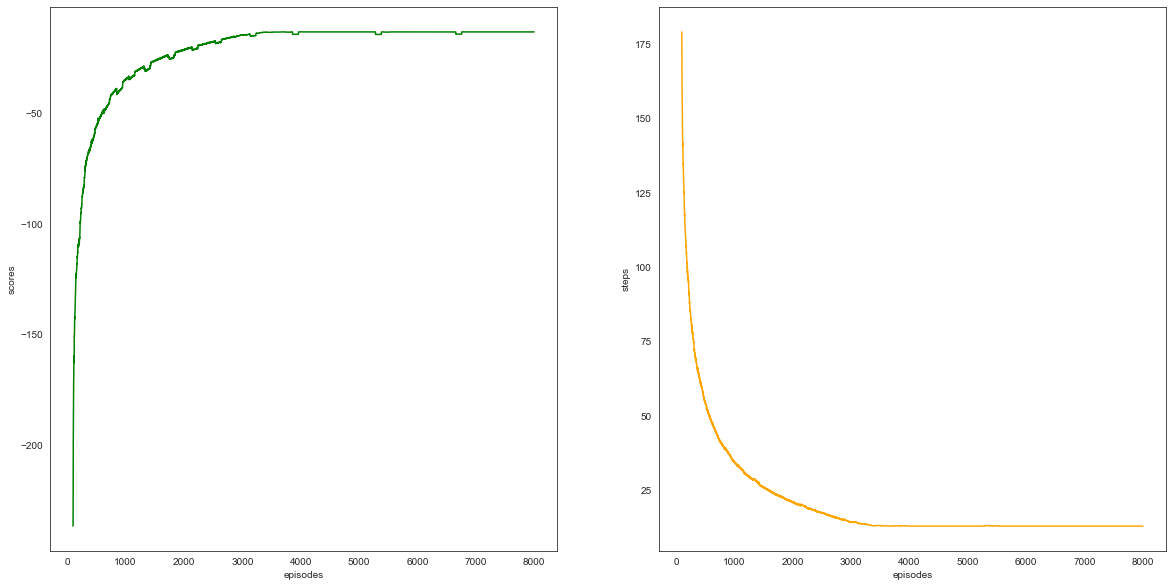

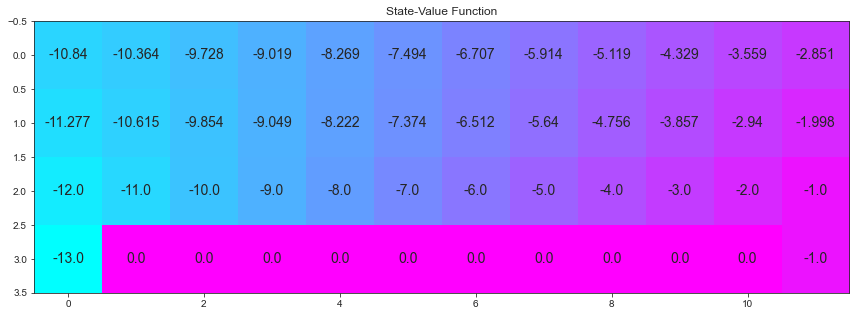

In [11]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 8000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [12]:
def learn_Q_sarsamax(Q, state, action, next_state, reward, done, gamma, alpha):
    predict = Q[state][action]
    target = reward + gamma *(0 if done else np.max(Q[next_state][:]))
    new = predict + alpha * (target - predict)
    return new

In [13]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    
    
    # initialize performance monitor
    ep_scores = []
    ep_steps = []
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        # monitor performance
        score = 0.
        step = 0
        
        ## TODO: complete the function
        
        ### set epsilon
        eps_i = min(0.1, 1. /i_episode )
        
        ### observe S0
        state = env.reset()
        
        
        ### repeat
        done = False
        while not done:
            ### choose action
            action = get_epsilon_greedy_action(Q, state, eps_i)
            
            ### Step through action
            next_state, reward, done, info = env.step(action)
            
            #### update Q
            Q[state][action] = learn_Q_sarsamax(Q, state, action, next_state, reward, done, gamma, alpha)
    
            #### t = t + 1
            state = next_state
            
            #### update performance metrics
            score += reward
            step += 1
        
        # track performance metrics
        ep_scores.append(score)
        ep_steps.append(step)
        
    # show performance metrics
    plot_metrics(ep_scores, ep_steps)
                                 
    return Q


array([0., 0., 0., 0.])

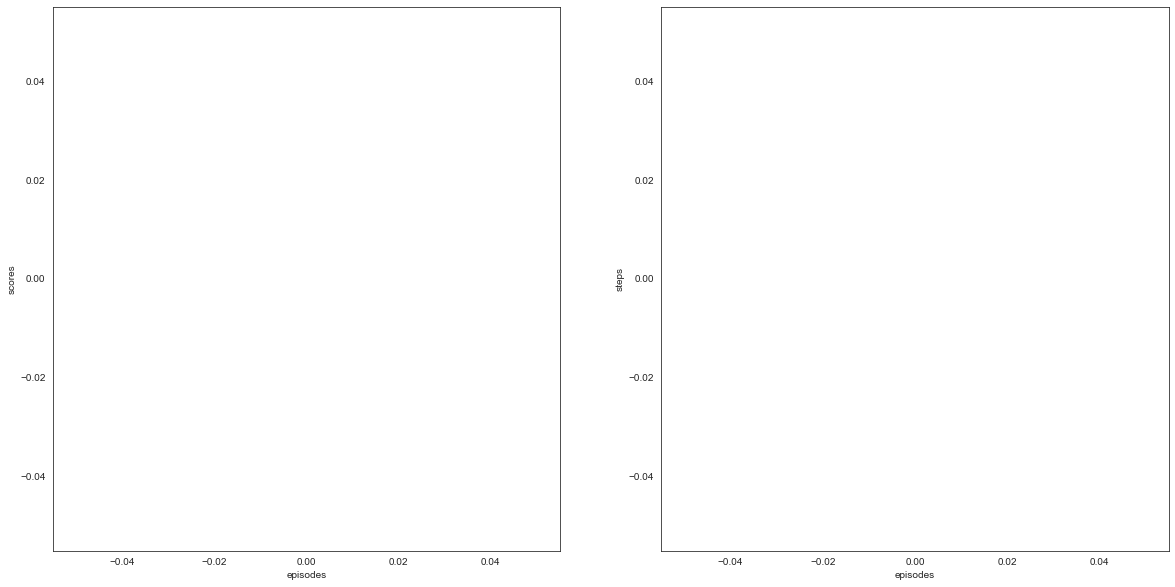

In [14]:
## Test the code runs
Q_sarsamax = q_learning(env, 10, 1)
Q_sarsamax[47]

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 20000/20000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  3  2  1  0  1  1  2  2  2  0  2]
 [ 0  1  1  1  1  2  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


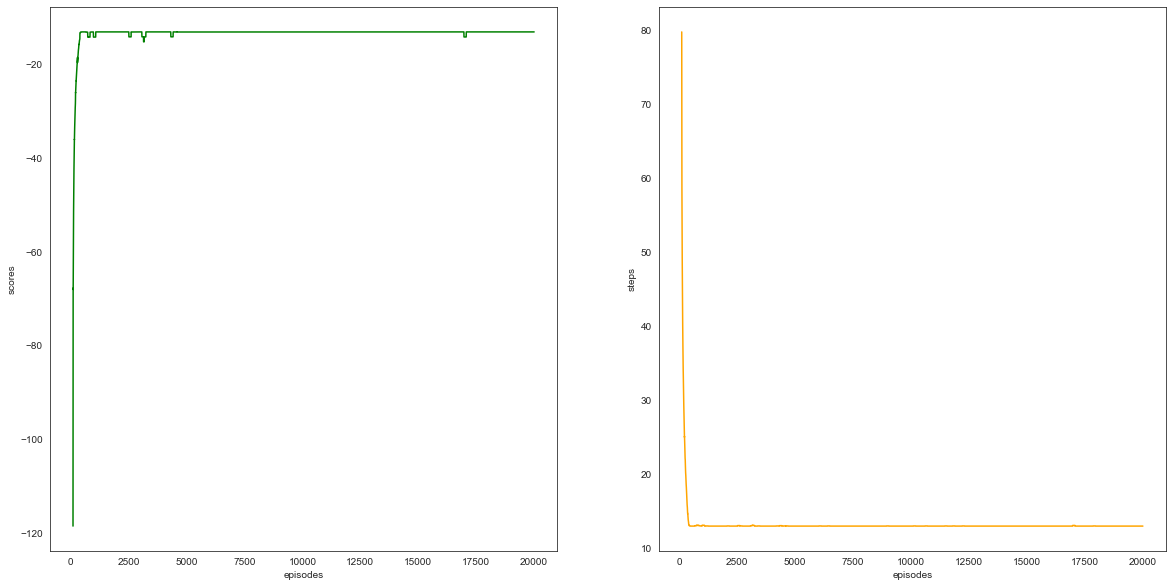

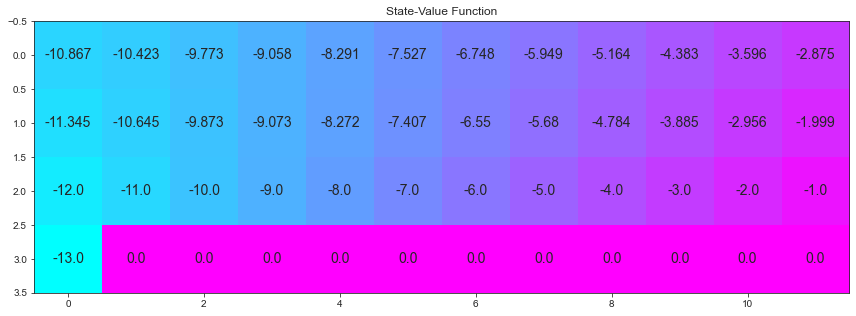

In [15]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 20000, .1)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [16]:
def get_expected_Q(Q, state, eps):
    nA = len(Q[state][:])
    probs = np.zeros(nA)
    probs += eps/nA
    
    ## For most probable action 1 - eps would be added
    max_action = np.argmax(Q[state][:])
    probs[max_action] += (1-eps)
    return np.sum(Q[state][:] * probs)

In [17]:
def learn_Q_sexpected_sarsa(Q, state, action, next_state, reward, done, gamma, alpha, eps):
    predict = Q[state][action]
    target = reward + gamma *(0 if done else get_expected_Q(Q, next_state, eps))
    new = predict + alpha * (target - predict)
    return new

In [18]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.action_space.n
    Q = defaultdict(lambda: -1 * np.ones(nA))
    
    
    # initialize performance monitor
    ep_scores = []
    ep_steps = []
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        # monitor performance
        score = 0.
        step = 0
        
        ## TODO: complete the function
        
        ### set epsilon
        eps_i = min(0.1, 1. /i_episode )
        
        ### observe S0
        state = env.reset()
        
        
        
        ### repeat
        done = False
        while not done:
            ### choose action A
            action = get_epsilon_greedy_action(Q, state, eps_i)
            
            ### Step throught the action
            next_state, reward, done, info = env.step(action)
            
            #### update Q
            Q[state][action] = learn_Q_sexpected_sarsa(Q, state, action, next_state, reward, done, gamma, alpha, eps_i)
    
            #### t = t + 1
            state = next_state
            
            #### update performance metrics
            score += reward
            step += 1
        
        # track performance metrics
        ep_scores.append(score)
        ep_steps.append(step)
        
    # show performance metrics
    plot_metrics(ep_scores, ep_steps)
                                 
    return Q


array([-1., -1., -1., -1.])

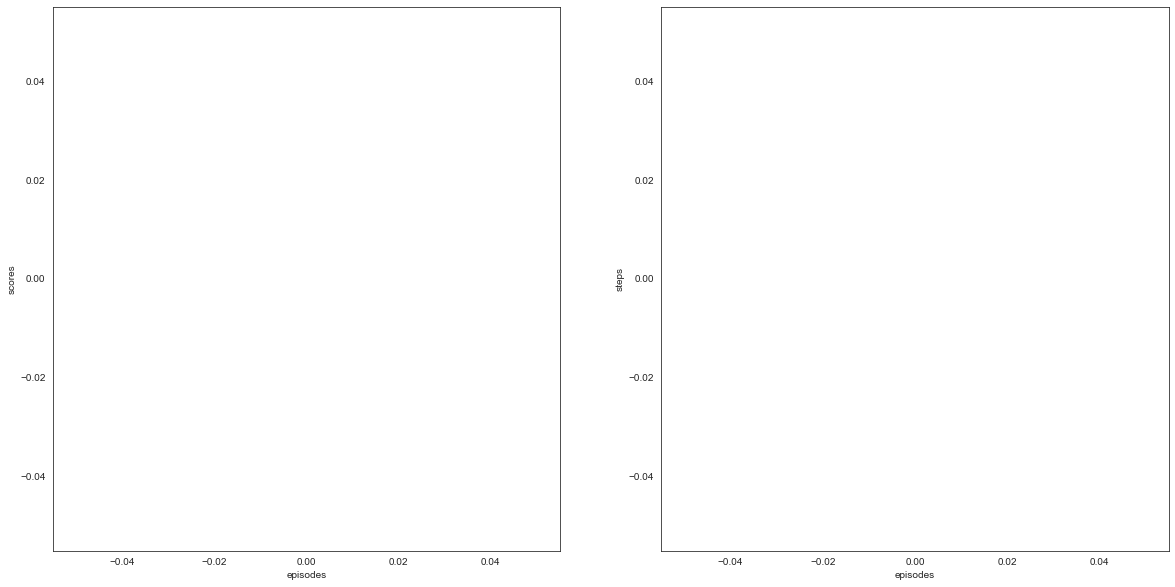

In [19]:
## Test the code runs
Q_expsarsa = expected_sarsa(env, 10, 1)
Q_expsarsa[47]

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  0  3  1  1  2  1  1  2  1  2]
 [ 0  1  1  2  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


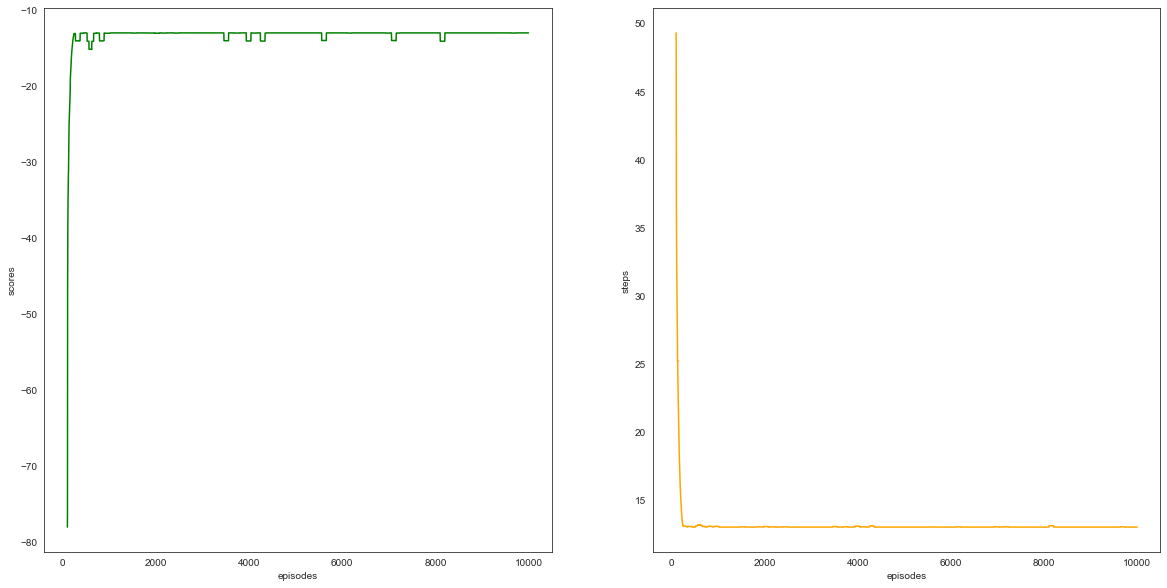

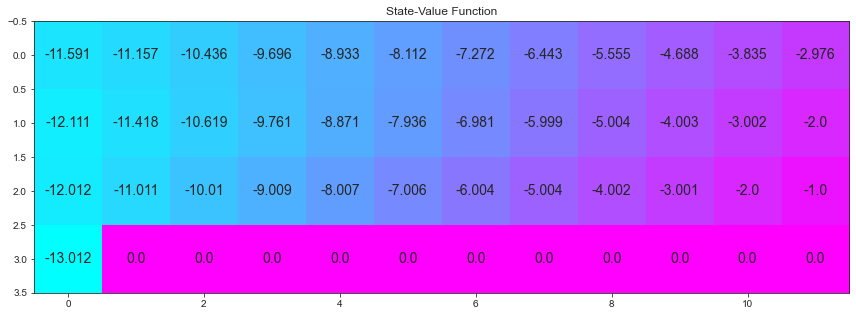

In [20]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 0.2)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

### Part 4: TD Control: TD(0)

In this section, you will write your own implementation of the TD(0) algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a one-dimensional arrays`V[s]` is the estimated state value corresponding to state `s` .


TD(0) learning is an algorithm to compute the value function of a given policy. So, we will determine value function of 2 policy : 
* Random Policy 
* Expected SARSA policy ( Q means policy )

In [21]:
TERMINAL_STATE = 47

In [22]:
def td0(env, num_episodes, alpha, gamma=1.0, policy={}, eps=1):
    # initialize action-value function (empty dictionary of arrays)
    V = np.zeros(env.nS)
    
    # initialize performance monitor
    ep_scores = []
    ep_steps = []
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 2 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        # monitor performance
        score = 0.
        step = 0
        
        ## TODO: complete the function
        
        ### set epsilon
        eps_i = min(0.1, 1. /i_episode )
        
        ### observe S0
        state = env.reset()
        
        
        
        ### repeat
        done = False
        while not done:
            ### choose action A from policy
            ## Random policy would be Q all zero with epsilon = 1
            ## Other Policy would be Q non empty with epsilon = 0.1
            action = get_epsilon_greedy_action(policy, state, eps)
            
            ### Step throught the action
            next_state, reward, done, info = env.step(action)
            
            #### update V
            predict = V[state]
            target = reward + gamma*(0 if done else V[next_state])
            V[state] = predict + alpha*(target - predict)
    
            #### t = t + 1
            state = next_state
            
            #### update performance metrics
            score += reward
            step += 1
        
        # track performance metrics
        ep_scores.append(score)
        ep_steps.append(step)
        
    # show performance metrics
    plot_metrics(ep_scores, ep_steps)
                                 
    return V


We will find a policy from next step and check this code.

Episode 1000/1000

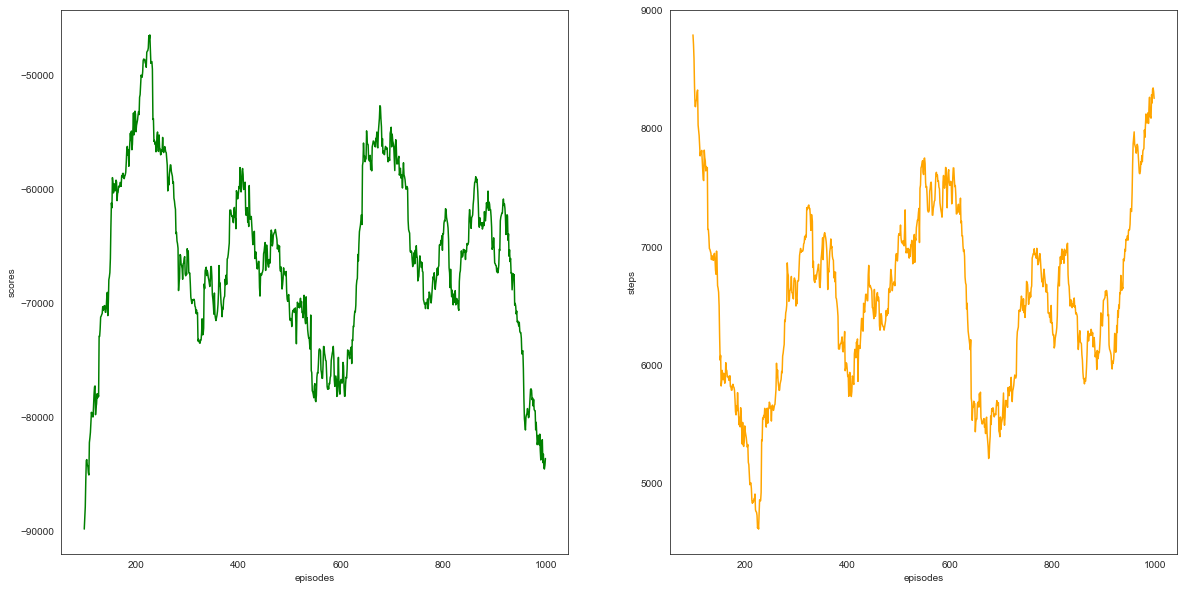

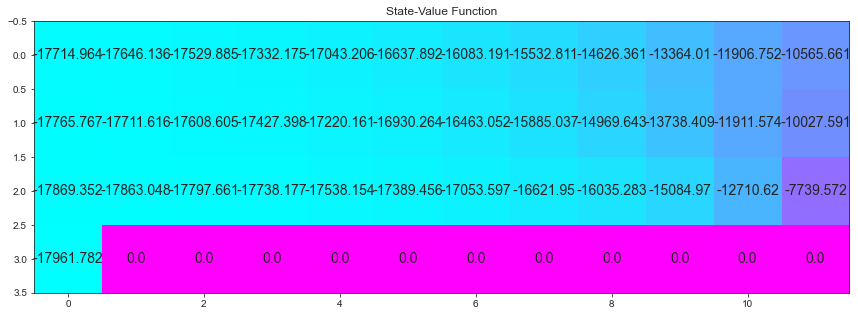

In [23]:
## Random policy
rand_policy = defaultdict(lambda : np.zeros(env.action_space.n))
eps = 1
V_rand = td0(env, 1000, .01, 1, rand_policy, eps)
plot_values(V_rand)

Episode 5000/5000

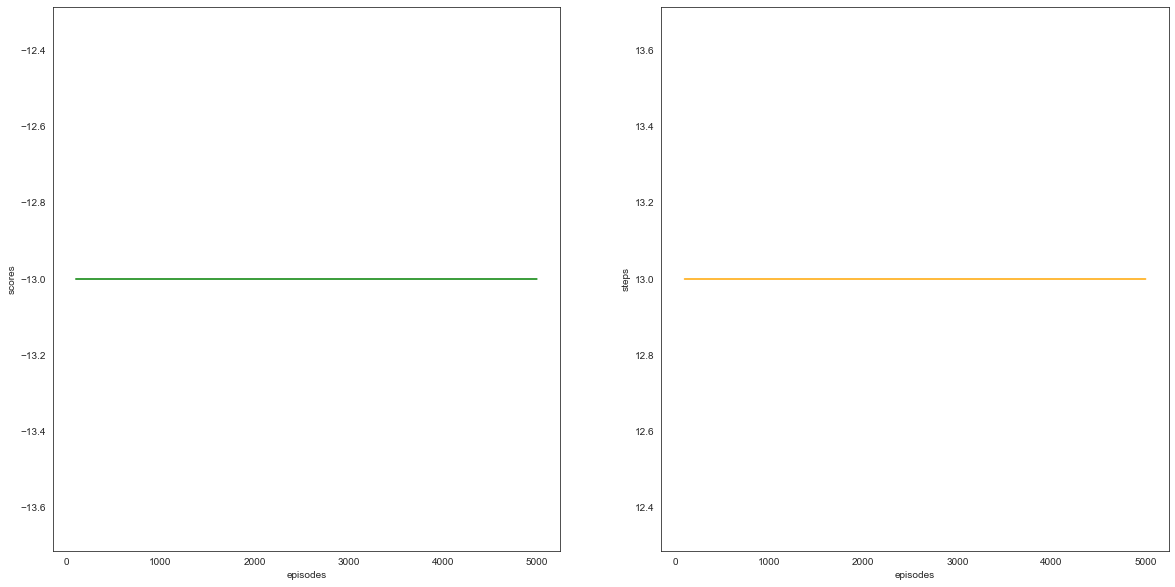

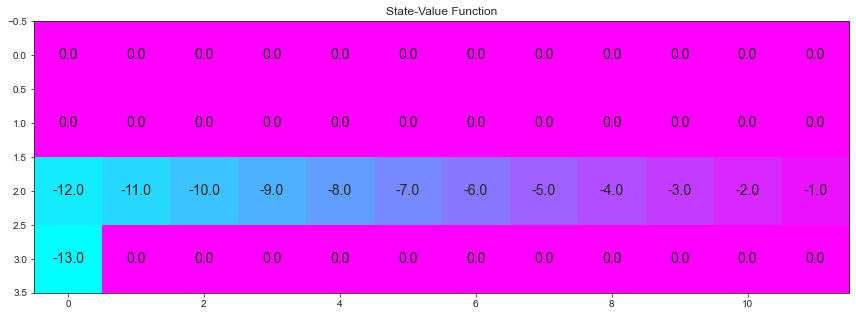

In [24]:
## Expected SARSA policy
expsarsa_policy = Q_expsarsa
eps = 0.0
V_expsarsa = td0(env, 5000, .01, 1, expsarsa_policy, eps)
plot_values(V_expsarsa)